# Templates
High-resolution models of emission/transmission are a key ingredient in HRCCS. When the model is ready for cross-correlation we call it a **template**. 

In this notebook we review some of the basic steps to convert a model into a template. 

To learn about how to generate such models we suggest to check out the excellent documentation of [petitRADTRANS](https://petitradtrans.readthedocs.io/en/latest/) or [PyratBay](https://pyratbay.readthedocs.io/en/latest/index.html).

## Read model
Models should contain two vectors (or three) of the same size: wavelength `wave`, planet flux `Fp` and (optionally) the planet continuum `Cp`.

Here we read a **CO** model covering the GIANO wavelength range (from 0.95 to 2.45 $\mu$m). This model has been generated using *thermochemical-equilibrium-chemistry*. 

The following procedure is generic and applies to any species/TP-profile/volume-mixing-ratio for **emission spectroscopy**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
# constants in CGS
c = 29979245800.0 # cm/s
h = 6.62606957e-27
kB = 1.3806488e-16 

def blackbody(T, nu):
    b = 2.*h*nu**3./c**2.
    b /= (np.exp(h*nu/kB/T)-1.)
    return b

The **emission** model $F_p$ must be scaled to the stellar flux $F_S$ and the transit depth $D=\left(\frac{R_P}{R_S}\right)^2$, hence the estimated emission from the planet is 

$$
    \text{emission} = \frac{F_{p}}{F_s}D \approx \frac{F_{p}}{B(T_{\text{eff}})}D
$$

Finally, we **normalise** the emission model by the *continuum* to obtain a suitable `template` to cross-correlate with our data.

$$
\text{continuum} \equiv C_p \approx B(T_{\text{eq}}) 
$$

$$
\text{template} = \frac{1 + \frac{F_{p}}{B(T_{\text{eff}})}D}{1 + \frac{C_p}{F_s}D}
$$
Note that the continuum signal must be scaled too.

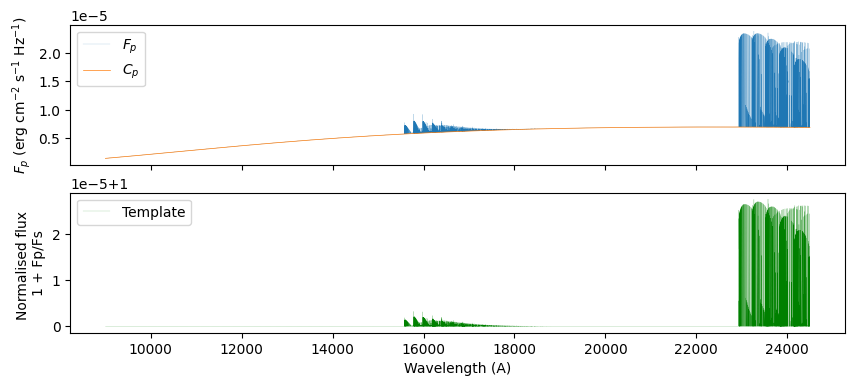

In [2]:
file = 'data/CO_tea_model.npy'
wave, Fp, Cp = np.load(file)

# Planet and star parameters
Rp, Rs = 1.679, 1.509
T_planet, T_star = 2273.5, 7400.
D = (Rp*0.01/Rs)**2 # transit depth

# Compute Black-Body function for the stellar continuum
freq = c/(wave*1e-8)
Fs = np.pi * blackbody(T_star, freq)

# Convert model to template
template = 1 + (D * Fp/Fs)
continuum = 1 + (D * Cp/Fs)
template /= continuum

# Plot results
fig, ax = plt.subplots(2, figsize=(10,4), sharex=True)
lw = 0.1
ax[0].plot(wave, Fp, lw=lw, label='$F_p$')
ax[0].plot(wave, Cp, lw=lw*5, label='$C_p$')

ax[1].plot(wave, template, lw=lw, c='g', label='Template')

ax[0].set(ylabel=r'$F_p$ (erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
ax[1].set(xlabel='Wavelength (A)', ylabel='Normalised flux \n1 + Fp/Fs')
[ax[i].legend() for i in range(2)]
plt.show()

The above code to scale and normalise the model is equivalent to the function `template.scale_model(T_star, transit_depth)`

In [3]:
from redcross import Template

template = Template(file=file)
template.scale_model(T_star, D)

## Autocorrelation function
To understand what the outcome of cross-correlating our data with a template might look like, we might want to investigate the shape of the *auto-correlation* function (ACF). 

To speed things up, we'll first crop the template to the region with strong CO emission lines (the right edge).

In [4]:
template.crop(22e3, 25e3) # arguments = (wavelength_min, wavelength_max) in same units as defined above

In [5]:
from redcross import CCF
# define RV-shift vector
RVs = np.arange(-200., 200.,0.5)

# Create CCF instance and call `autoccf`
ccf = CCF(RVs, template).autoccf()

Plot the results, zooming-in around RV = 0 km/s on the right subplot

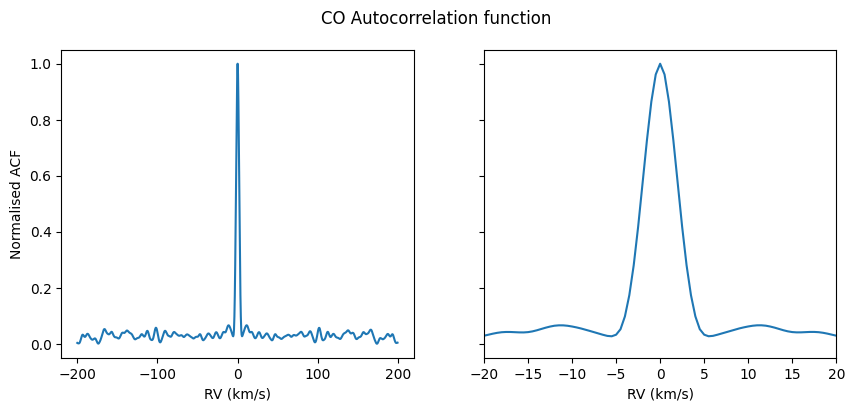

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)

for i in range(2):
    f  = ccf.flux - ccf.flux.min()
    ax[i].plot(ccf.rv, f / f.max())
    ax[i].set(xlabel='RV (km/s)')
ax[1].set(xlim=(-20, 20.))
ax[0].set(ylabel='Normalised ACF')
fig.suptitle('CO Autocorrelation function')

plt.show()